In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

![Alt text](image.png)

description from Interactive Image Segmentation with Latent Diversity

code from Reviving Iterative Training with Mask Guidance for Interactive Segmentation

In [24]:
# https://github.com/SamsungLabs/ritm_interactive_segmentation/blob/b9b44603672e15aa0be878b54fd26e7e1c5d2311/isegm/data/points_sampler.py#L290
import random
def get_point_candidates(obj_mask, k=1.7, full_prob=0.0):
    if full_prob > 0 and random.random() < full_prob:
        return obj_mask

    padded_mask = np.pad(obj_mask, ((1, 1), (1, 1)), 'constant')

    dt = cv2.distanceTransform(padded_mask.astype(np.uint8), cv2.DIST_L2, 0)[1:-1, 1:-1]
    if k > 0:
        inner_mask = dt > dt.max() / k
        return np.argwhere(inner_mask)
    else:
        prob_map = dt.flatten()
        prob_map /= max(prob_map.sum(), 1e-6)
        click_indx = np.random.choice(len(prob_map), p=prob_map)
        click_coords = np.unravel_index(click_indx, dt.shape)
        return np.array([click_coords])

In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
def gt_to_anns(mask_gt):
    labels = np.unique(mask_gt)
    anns = []
    for label in labels:
        # skip background
        if label == 0:
            continue
        mask = np.all(mask_gt == label, axis=-1)
        center_point = get_point_candidates(mask,1 + 1e-6)
        # 1 ramdon point from mask
        num_point = 1
        indices = np.argwhere(mask)
        # swap x y
        indices[:,[1,0]] = indices[:,[0,1]]
        center_point[:,[1,0]] = center_point[:,[0,1]]
        # sample on random point
        point = indices[np.random.randint(indices.shape[0], size=num_point)]
        # all point for test
        points = indices
        anns.append({
            'area': np.sum(mask),
            'segmentation': mask,
            'label': label,
            'random_point_1':point,
            'center_point_1': center_point,
            'points':points,
        })
    return anns
def ShowSamplePoint(ann,show_all_point_in_mask = False,point_name = 'random_point_1'):
    if show_all_point_in_mask:
        input_point = ann['points']
    else:
        input_point = ann[point_name]
    point_labels = np.ones(input_point.shape[0])
    show_points(input_point, point_labels, plt.gca())

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device)

In [4]:
predictor = SamPredictor(sam)

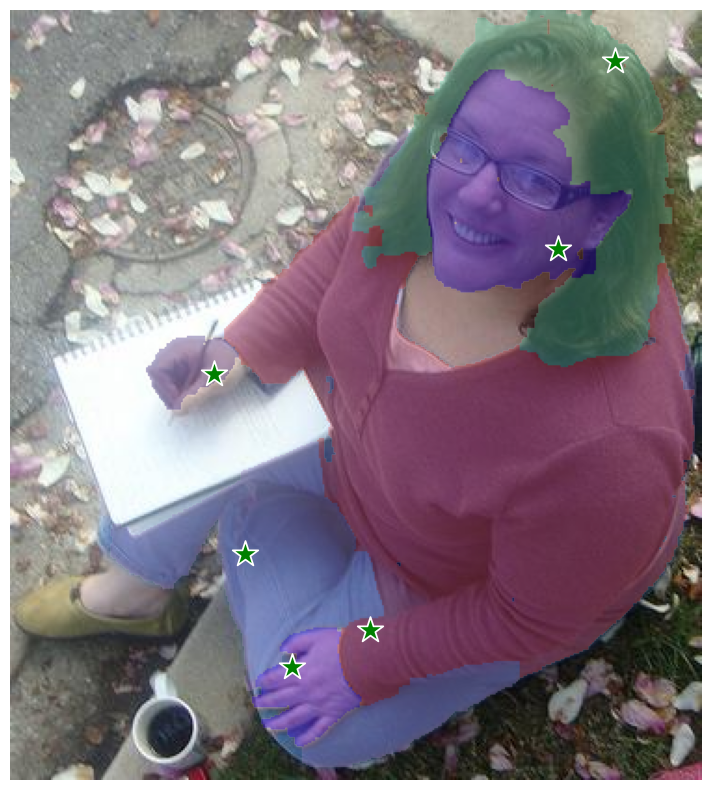

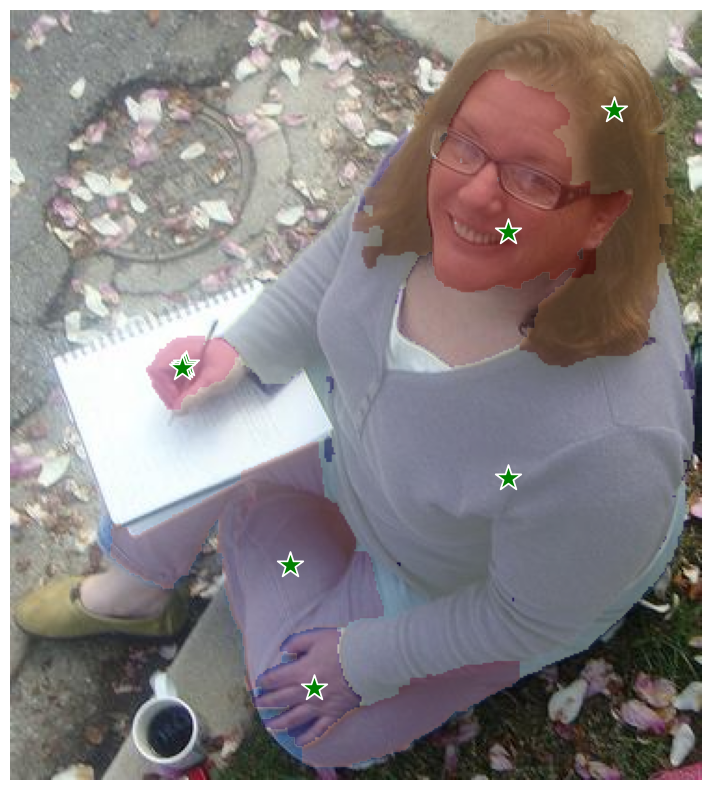

In [25]:
# test gt_to_anns
path = "../datasets/people_poses/"
image = cv2.imread(path +'val_images/547336_495052.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_gt = cv2.imread(path + 'val_segmentations/547336_495052.png')
anns = gt_to_anns(mask_gt)
# show_all_point_in_mask = False
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_anns(anns)
# ShowSamplePoint(anns[0],True)
# plt.axis('off')
# plt.show() 


plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(anns)
for ann in anns:
    ShowSamplePoint(ann)
plt.axis('off')
plt.show() 

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(anns)
for ann in anns:
    ShowSamplePoint(ann,point_name='center_point_1')
plt.axis('off')
plt.show() 

In [ ]:
# numpy version
def pixAcc(predicted, target):
    same = (predicted == target).sum()
    w, h = target.shape
    return same / (w * h)

# input: bool matrix
def IOU(predicted , target):
    intersection = np.logical_and(target, predicted).sum()
    union = np.logical_or(target, predicted).sum()
    if union == 0:
        iou_score = 0
    else :
        iou_score = intersection / union
    return iou_score

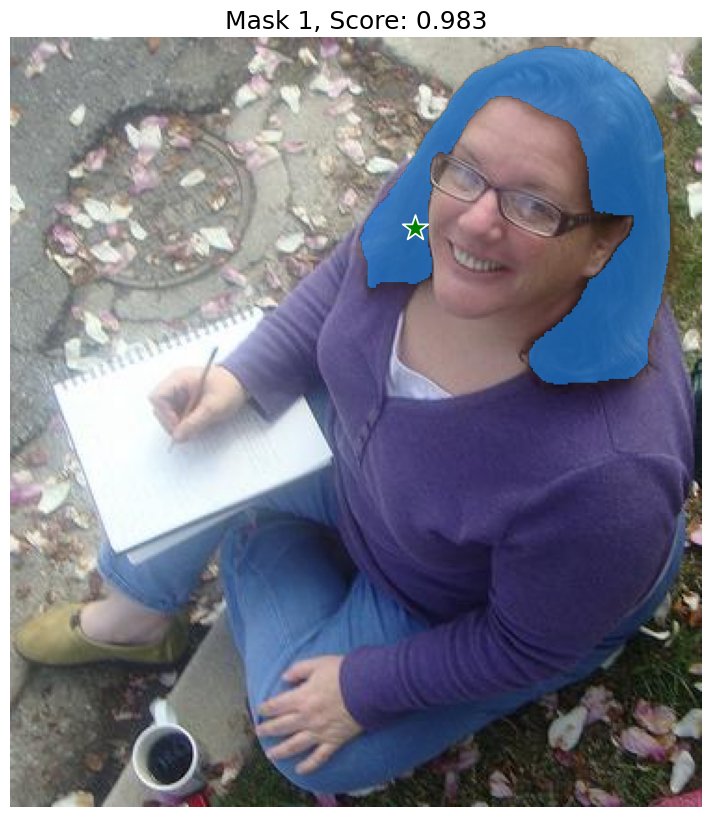

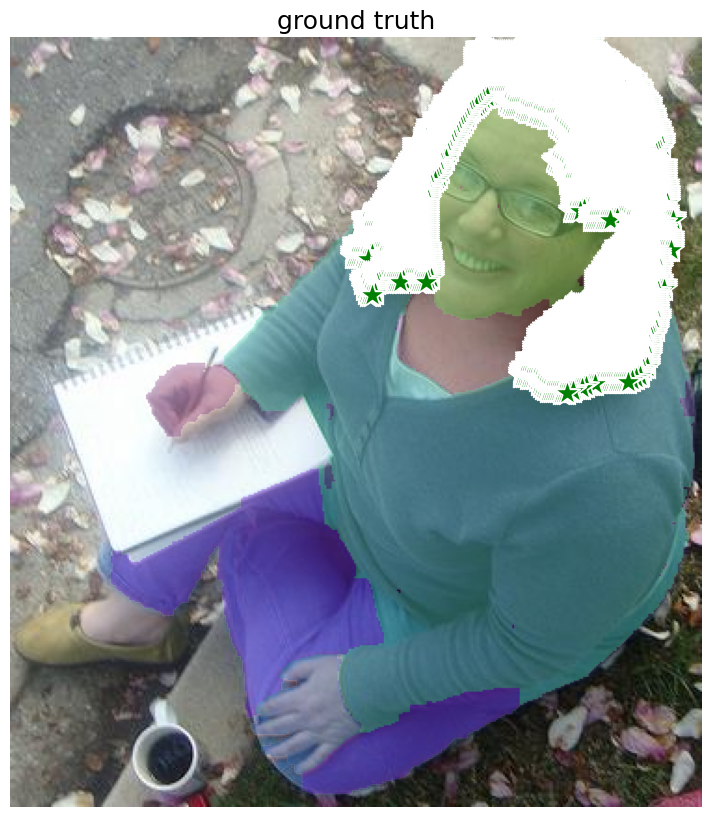

0.8217072051399724


In [12]:

predictor.set_image(image)
input_point = anns[0]['random_point_1']
input_label = np.array([1])
label = anns[0]['label']
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False)
pre_eval_results = []
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_anns(anns)
    ShowSamplePoint(anns[0],True)
    plt.title(f"ground truth", fontsize=18)
    plt.axis('off')
    plt.show() 
    mask_np = mask
    mask_gt_np = anns[0]['segmentation']
    print(IOU(mask_np,mask_gt_np))



In [22]:
# numpy metrics
import os
from tqdm import tqdm
root = "../datasets/people_poses/"
with open(os.path.join(root, f"val_id.txt"), 'r') as lf:
    data_list = [ s.strip() for s in lf.readlines() ]


num_valid_case, sum_miou, sum_pixAcc = 0,0,0
for data_name in (pbar := tqdm(data_list)):
    image = cv2.imread(root +'val_images/' + data_name + '.jpg')
    if image is None:
        print("image is None", data_name)
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gt = cv2.imread(root + 'val_segmentations/' + data_name + '.png')
    if mask_gt is None:
        print("mask_gt is None", data_name)
        continue
    anns = gt_to_anns(mask_gt)
    predictor.set_image(image)
    img_miou_sum , img_pixacc_sum, num_class = 0, 0, len(anns)
    for ann in anns:
        target = ann['segmentation']
        input_point = ann['random_point_1']
        input_label = np.array([1])
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
        )
        iou = IOU(masks[0],ann['segmentation'])
        pixacc = pixAcc(masks[0],ann['segmentation'])
        img_miou_sum += iou
        img_pixacc_sum += pixacc
    if num_class > 0:
        img_iou = img_miou_sum/num_class
        img_pixacc = img_pixacc_sum/num_class
        sum_miou += img_iou
        sum_pixAcc += img_pixacc
        num_valid_case += 1
        pbar.set_description("current pixAcc: {:.3f}, mIoU: {:.3f}".format(
                    img_pixacc, img_iou))
    else:
        print(data_name)
    
print("num_valid_case:", num_valid_case)
print("mIoU:", sum_miou / num_valid_case)
print("Acc:", sum_pixAcc / num_valid_case)

current pixAcc: 0.988, mIoU: 0.657:   0%|          | 16/10000 [00:18<3:13:13,  1.16s/it]

100985_570554


current pixAcc: 0.884, mIoU: 0.311:   4%|▎         | 359/10000 [07:19<3:16:35,  1.22s/it]


KeyboardInterrupt: 